In [ ]:
!pip install fastbook

In [6]:
from google.colab import files

uploaded = files.upload()

Saving colab_keys.json to colab_keys.json


In [7]:
import os
import json
from fastbook import search_images_bing, download_url

if uploaded:
  api_key = json.loads(uploaded.get('colab_keys.json')).get('AZURE_API_KEY')
else:
  api_key = os.environ.get("AZURE_API_KEY", 'XXX')


In [17]:
from fastbook import Path, download_images, get_image_files

bear_types = ['grizzly', 'black', 'teddy']
path = Path('bears')
if not path.exists():
    path.mkdir()
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(api_key, f'{o} bear')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [18]:
import fastbook
fns = get_image_files(path)
failed = fastbook.verify_images(fns)
failed.map(Path.unlink)

(#1) [None]

In [30]:
import fastbook

bears = fastbook.DataBlock(
    blocks = (fastbook.ImageBlock, fastbook.CategoryBlock),
    get_items=fastbook.get_image_files,
    splitter=fastbook.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=fastbook.parent_label,
    item_tfms=fastbook.Resize(128, fastbook.ResizeMethod.Pad, pad_mode='zeros')
)

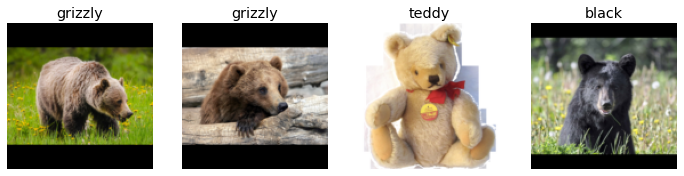

In [20]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bears = bears.new(item_tfms=fastbook.RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
bears = bears.new(item_tfms=fastbook.Resize(128), batch_tfms=fastbook.aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [31]:
path = fastbook.Path('bears')
bears = bears.new(
    item_tfms=fastbook.RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=fastbook.aug_transforms())
dls = bears.dataloaders(path)


In [37]:
learn = fastbook.vision_learner(dls, fastbook.resnet18, metrics=fastbook.error_rate)
learn.fine_tune(6)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.241037,1.180089,0.444444,00:13


epoch,train_loss,valid_loss,error_rate,time
0,2.006661,0.731099,0.333333,00:14
1,1.743530,0.253273,0.074074,00:13
2,1.413367,0.086927,0.000000,00:13
3,1.106701,0.043683,0.000000,00:14
4,0.919280,0.032448,0.000000,00:13
5,0.783076,0.027560,0.000000,00:14


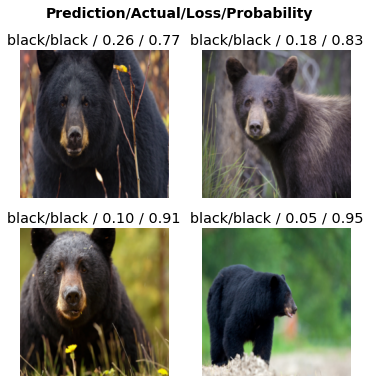

In [38]:
interp = fastbook.ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4)

In [34]:

from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

In [27]:
import shutil

for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [42]:
learn.export('bear_classifier.pkl')

In [43]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('bear_classifier.pkl')]

In [45]:
learn_inf = fastbook.load_learner(path/'bear_classifier.pkl')
learn_inf.predict('bears/grizzly/04e1fc89-b921-4b80-85bc-8ef697b2d938.jpg')

('grizzly', TensorBase(1), TensorBase([4.2874e-02, 9.5706e-01, 6.1366e-05]))

In [46]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']